In [13]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sk
import pickle
import mne
import tqdm
from tqdm import trange
import os

DEVICE='cuda'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from torch import nn

In [14]:
def extract_data(sub_range,verbose=False,feature_func=None,**kwargs):
    first=sub_range[0]
    last=sub_range[-1]

    for sub in trange(first,last+1): 
        #read data
        if sub <=9:
            path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
        else:
            path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-vid_task-emotion_reorder.npy'
        datatemp=np.load(path,allow_pickle=True)
        datatemp=np.permute_dims(datatemp,[1,0,2])

        #if we want to convert features
        if not feature_func==None:
            datatemp=feature_func(datatemp,info=info)

        #cat data along new dimension
        datatemp=torch.tensor(datatemp).unsqueeze(0)
        if sub==first:
            data=datatemp
        else:
            data=torch.cat([data,datatemp],axis=0)

        if verbose:
            print(f'subject {sub} data extracted, vector size: {data.shape}')
    return data

def shuffle_and_split_data(X,y):
    """
    Helper function to shuffle and split data

    Args:
        X: torch.tensor
        Input data
        y: torch.tensor
        Corresponding target variables
        seed: int
        Set seed for reproducibility

    Returns:
        X_test: torch.tensor
        Test data [20% of X]
        y_test: torch.tensor
        Labels corresponding to above mentioned test data
        X_train: torch.tensor
        Train data [80% of X]
        y_train: torch.tensor
        Labels corresponding to above mentioned train data
    """
    
    N=X.size(0)
    shuffled_indices=torch.randperm(N) #get shuffled indices
    X=X[shuffled_indices]
    y=y[shuffled_indices]

    # split by 20% into train-test set
    test_size=int(0.2*N)
    X_train=X[test_size:]
    y_train=y[test_size:]
    X_test=X[:test_size]
    y_test=y[:test_size]

    return X_test,y_test,X_train,y_train

#create labels
#sad-dis-fear-neu-joy-ten-ins correspond to 0-6 respectively, each sample has 21 trials, for (7 emotions x 3 trials)
labels=np.array([])
for i in range(0,7):
    for n in range(0,3):
        labels=np.concatenate([labels,np.array([i])],axis=0)
labels=torch.tensor(labels)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\malco\AppData\Local\Temp\ipykernel_13100\2464512495.py:8: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_13100\2464512495.py:8: SyntaxWarning: invalid escape sequence '\s'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_13100\2464512495.py:10: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-

In [15]:
data=extract_data([1,20])

100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


In [16]:
def process_data(data):
    '''0-10s, 5-15s, 10-20s, 15-25, 20-30s ---> 5 samples per trial'''
    for interval in tqdm.tqdm(range(0,5)):
        datatrial=data[:,:,:,interval*1000:(interval+2)*1000]
        datatrial=torch.unsqueeze(datatrial,2)
        if interval==0:
            newdata=datatrial
        else:
            newdata=torch.concatenate((newdata,datatrial),2)
    return newdata

In [17]:
data=process_data(data)
data.shape #subject,label,trials,electrodes,timepoints

100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


torch.Size([20, 21, 5, 64, 2000])

In [18]:
for label in tqdm.tqdm(range(21)): #combine labels and trials
    temp=data[:,label,:,:,:]
    if label==0:
        X=temp
        y=labels[label]*torch.ones(5,1)
    else:
        X=torch.concatenate((X,temp),dim=1)
        y=torch.concatenate((y,labels[label]*torch.ones(5,1)),dim=0)

#combine subjects
for subject in tqdm.tqdm(range(X.size(0))):
    temp=X[subject,:,:,:]
    if subject==0:
        X_full=temp
        y_full=y
    else:
        X_full=torch.concatenate((X_full,temp),dim=0)
        y_full=torch.concatenate((y_full,y),dim=0)

print(X_full.shape)
print(y_full.shape)

#split data
X_test,y_test,X_train,y_train=shuffle_and_split_data(X_full,y_full.squeeze())

print(X_test.shape,y_test.shape,
      X_train.shape,y_train.shape)

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


torch.Size([2100, 64, 2000])
torch.Size([2100, 1])
torch.Size([420, 64, 2000]) torch.Size([420]) torch.Size([1680, 64, 2000]) torch.Size([1680])


In [21]:
#now the model
class Net(nn.Module):
    def __init__(self,dropout):
        super(Net,self).__init__()
        self.conv1=nn.Conv1d(64,128,kernel_size=7,padding=3)
        self.conv2=nn.Conv1d(128,96,kernel_size=9,padding=4)
        self.conv3=nn.Conv1d(96,64,kernel_size=5,padding=2)
        self.conv4=nn.Conv1d(64,8,kernel_size=3,padding=1)
        self.pool=nn.MaxPool1d(2)
        self.fc1=nn.Linear(8000,4000)
        self.fc2=nn.Linear(4000,4000)
        self.fc3=nn.Linear(4000,7)
        self.dropoutlayer=nn.Dropout1d(0.4)
        self.batchnorm1=nn.BatchNorm1d(128)
        self.batchnorm2=nn.BatchNorm1d(96)
        self.batchnorm3=nn.BatchNorm1d(64)
        self.batchnorm4=nn.BatchNorm1d(8)

    def forward(self,x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.dropoutlayer(x) 
        x=nn.functional.relu(x)       

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.dropoutlayer(x) 
        x=nn.functional.relu(x)       

        x=self.conv4(x)
        x=self.batchnorm4(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)
        x=self.pool(x)
        
        x=torch.flatten(x,1)

        x=self.fc1(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.fc2(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.fc3(x)


        return x
    


def train_test(net,epochs,train_loader,test_loader,device):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=1e-3,weight_decay=1e-4)
    train_acc=[]
    train_loss=[]
    test_acc=[]
    test_loss=[]
    net.to(device)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss=0.0
        correct,total=0,0
        for i,data in enumerate(train_loader,start=0):
            inputs,labels=data
            inputs=inputs.to(device).float()
            labels=labels.to(device).long()
            
            #train
            optimizer.zero_grad()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()
            #training accuracy
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
        print(f"epoch {epoch} --> TRAIN loss: {running_loss/len(train_loader):.5f}, TRAIN accuracy: {correct/total:.2f}")

        #eval on test
        net.eval()
        running_loss=0.0
        correct,total=0,0
        for inputs,labels in test_loader:
            inputs,labels=inputs.to(device).float(),labels.to(device).long()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()

            #test acc
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)
        print(f"epoch {epoch} --> TEST loss: {running_loss/len(train_loader):.2f}, TEST accuracy: {correct/total:.2f}")

    return train_loss,train_acc,test_loss,test_acc


batch_size=300
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False,num_workers=0
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=False,
                          shuffle=True,num_workers=0
                          )

In [23]:
net=Net(dropout=0.3)
train_loss,train_acc,test_loss,test_acc=train_test(net,200,train_loader=train_loader,test_loader=test_loader,device=DEVICE)

  0%|          | 1/200 [00:01<05:22,  1.62s/it]

epoch 0 --> TRAIN loss: 5.77678, TRAIN accuracy: 0.14
epoch 0 --> TEST loss: 0.67, TEST accuracy: 0.15


  1%|          | 2/200 [00:02<04:43,  1.43s/it]

epoch 1 --> TRAIN loss: 1.96149, TRAIN accuracy: 0.13
epoch 1 --> TEST loss: 0.65, TEST accuracy: 0.15


  2%|▏         | 3/200 [00:04<04:31,  1.38s/it]

epoch 2 --> TRAIN loss: 1.95742, TRAIN accuracy: 0.14
epoch 2 --> TEST loss: 0.65, TEST accuracy: 0.17


  2%|▏         | 4/200 [00:05<04:24,  1.35s/it]

epoch 3 --> TRAIN loss: 1.95246, TRAIN accuracy: 0.14
epoch 3 --> TEST loss: 0.65, TEST accuracy: 0.14


  2%|▎         | 5/200 [00:06<04:19,  1.33s/it]

epoch 4 --> TRAIN loss: 1.94639, TRAIN accuracy: 0.14
epoch 4 --> TEST loss: 0.65, TEST accuracy: 0.12


  3%|▎         | 6/200 [00:08<04:17,  1.33s/it]

epoch 5 --> TRAIN loss: 1.94790, TRAIN accuracy: 0.14
epoch 5 --> TEST loss: 0.65, TEST accuracy: 0.12


  4%|▎         | 7/200 [00:09<04:15,  1.32s/it]

epoch 6 --> TRAIN loss: 1.94574, TRAIN accuracy: 0.15
epoch 6 --> TEST loss: 0.65, TEST accuracy: 0.12


  4%|▍         | 8/200 [00:10<04:14,  1.33s/it]

epoch 7 --> TRAIN loss: 1.95113, TRAIN accuracy: 0.15
epoch 7 --> TEST loss: 0.65, TEST accuracy: 0.12


  4%|▍         | 9/200 [00:12<04:14,  1.33s/it]

epoch 8 --> TRAIN loss: 1.93769, TRAIN accuracy: 0.17
epoch 8 --> TEST loss: 0.65, TEST accuracy: 0.13


  5%|▌         | 10/200 [00:13<04:20,  1.37s/it]

epoch 9 --> TRAIN loss: 1.93543, TRAIN accuracy: 0.16
epoch 9 --> TEST loss: 0.65, TEST accuracy: 0.12


  6%|▌         | 11/200 [00:15<04:21,  1.38s/it]

epoch 10 --> TRAIN loss: 1.93897, TRAIN accuracy: 0.15
epoch 10 --> TEST loss: 0.65, TEST accuracy: 0.12


  6%|▌         | 12/200 [00:16<04:18,  1.37s/it]

epoch 11 --> TRAIN loss: 1.94320, TRAIN accuracy: 0.16
epoch 11 --> TEST loss: 0.65, TEST accuracy: 0.12


  6%|▋         | 13/200 [00:17<04:15,  1.36s/it]

epoch 12 --> TRAIN loss: 1.94844, TRAIN accuracy: 0.17
epoch 12 --> TEST loss: 0.65, TEST accuracy: 0.13


  7%|▋         | 14/200 [00:19<04:12,  1.36s/it]

epoch 13 --> TRAIN loss: 1.94744, TRAIN accuracy: 0.15
epoch 13 --> TEST loss: 0.66, TEST accuracy: 0.15


  8%|▊         | 15/200 [00:20<04:11,  1.36s/it]

epoch 14 --> TRAIN loss: 1.93776, TRAIN accuracy: 0.16
epoch 14 --> TEST loss: 0.66, TEST accuracy: 0.15


  8%|▊         | 16/200 [00:21<04:09,  1.36s/it]

epoch 15 --> TRAIN loss: 1.93351, TRAIN accuracy: 0.15
epoch 15 --> TEST loss: 0.65, TEST accuracy: 0.13


  8%|▊         | 17/200 [00:23<04:09,  1.37s/it]

epoch 16 --> TRAIN loss: 1.93990, TRAIN accuracy: 0.16
epoch 16 --> TEST loss: 0.65, TEST accuracy: 0.14


  9%|▉         | 18/200 [00:24<04:11,  1.38s/it]

epoch 17 --> TRAIN loss: 1.94135, TRAIN accuracy: 0.15
epoch 17 --> TEST loss: 0.65, TEST accuracy: 0.15


 10%|▉         | 19/200 [00:25<04:10,  1.38s/it]

epoch 18 --> TRAIN loss: 1.92842, TRAIN accuracy: 0.17
epoch 18 --> TEST loss: 0.65, TEST accuracy: 0.16


 10%|█         | 20/200 [00:27<04:11,  1.40s/it]

epoch 19 --> TRAIN loss: 1.93528, TRAIN accuracy: 0.17
epoch 19 --> TEST loss: 0.65, TEST accuracy: 0.12


 10%|█         | 21/200 [00:28<04:08,  1.39s/it]

epoch 20 --> TRAIN loss: 1.94063, TRAIN accuracy: 0.17
epoch 20 --> TEST loss: 0.65, TEST accuracy: 0.11


 11%|█         | 22/200 [00:30<04:06,  1.38s/it]

epoch 21 --> TRAIN loss: 1.93546, TRAIN accuracy: 0.17
epoch 21 --> TEST loss: 0.65, TEST accuracy: 0.14


 12%|█▏        | 23/200 [00:31<04:03,  1.38s/it]

epoch 22 --> TRAIN loss: 1.93537, TRAIN accuracy: 0.16
epoch 22 --> TEST loss: 0.65, TEST accuracy: 0.12


 12%|█▏        | 24/200 [00:32<04:03,  1.39s/it]

epoch 23 --> TRAIN loss: 1.93385, TRAIN accuracy: 0.16
epoch 23 --> TEST loss: 0.66, TEST accuracy: 0.12


 12%|█▎        | 25/200 [00:34<04:02,  1.38s/it]

epoch 24 --> TRAIN loss: 1.93916, TRAIN accuracy: 0.16
epoch 24 --> TEST loss: 0.65, TEST accuracy: 0.13


 13%|█▎        | 26/200 [00:35<04:00,  1.38s/it]

epoch 25 --> TRAIN loss: 1.92153, TRAIN accuracy: 0.17
epoch 25 --> TEST loss: 0.65, TEST accuracy: 0.14


 14%|█▎        | 27/200 [00:37<03:59,  1.39s/it]

epoch 26 --> TRAIN loss: 1.93189, TRAIN accuracy: 0.16
epoch 26 --> TEST loss: 0.66, TEST accuracy: 0.11


 14%|█▍        | 28/200 [00:38<03:58,  1.39s/it]

epoch 27 --> TRAIN loss: 1.91830, TRAIN accuracy: 0.17
epoch 27 --> TEST loss: 0.66, TEST accuracy: 0.11


 14%|█▍        | 29/200 [00:39<03:57,  1.39s/it]

epoch 28 --> TRAIN loss: 1.92406, TRAIN accuracy: 0.17
epoch 28 --> TEST loss: 0.65, TEST accuracy: 0.15


 15%|█▌        | 30/200 [00:41<03:56,  1.39s/it]

epoch 29 --> TRAIN loss: 1.91716, TRAIN accuracy: 0.18
epoch 29 --> TEST loss: 0.66, TEST accuracy: 0.15


 16%|█▌        | 31/200 [00:42<03:55,  1.39s/it]

epoch 30 --> TRAIN loss: 1.93328, TRAIN accuracy: 0.17
epoch 30 --> TEST loss: 0.66, TEST accuracy: 0.11


 16%|█▌        | 32/200 [00:44<03:53,  1.39s/it]

epoch 31 --> TRAIN loss: 1.91969, TRAIN accuracy: 0.17
epoch 31 --> TEST loss: 0.66, TEST accuracy: 0.11


 16%|█▋        | 33/200 [00:45<03:52,  1.39s/it]

epoch 32 --> TRAIN loss: 1.91157, TRAIN accuracy: 0.17
epoch 32 --> TEST loss: 0.66, TEST accuracy: 0.11


 17%|█▋        | 34/200 [00:46<03:50,  1.39s/it]

epoch 33 --> TRAIN loss: 1.92430, TRAIN accuracy: 0.17
epoch 33 --> TEST loss: 0.66, TEST accuracy: 0.13


 18%|█▊        | 35/200 [00:48<03:49,  1.39s/it]

epoch 34 --> TRAIN loss: 1.91535, TRAIN accuracy: 0.17
epoch 34 --> TEST loss: 0.67, TEST accuracy: 0.13


 18%|█▊        | 36/200 [00:49<03:48,  1.39s/it]

epoch 35 --> TRAIN loss: 1.93001, TRAIN accuracy: 0.17
epoch 35 --> TEST loss: 0.66, TEST accuracy: 0.12


 18%|█▊        | 37/200 [00:50<03:47,  1.40s/it]

epoch 36 --> TRAIN loss: 1.90329, TRAIN accuracy: 0.19
epoch 36 --> TEST loss: 0.66, TEST accuracy: 0.13


 19%|█▉        | 38/200 [00:52<03:46,  1.40s/it]

epoch 37 --> TRAIN loss: 1.92698, TRAIN accuracy: 0.17
epoch 37 --> TEST loss: 0.66, TEST accuracy: 0.14


 20%|█▉        | 39/200 [00:53<03:44,  1.40s/it]

epoch 38 --> TRAIN loss: 1.92519, TRAIN accuracy: 0.16
epoch 38 --> TEST loss: 0.67, TEST accuracy: 0.13


 20%|██        | 40/200 [00:55<03:43,  1.40s/it]

epoch 39 --> TRAIN loss: 1.91137, TRAIN accuracy: 0.18
epoch 39 --> TEST loss: 0.67, TEST accuracy: 0.13


 20%|██        | 41/200 [00:56<03:42,  1.40s/it]

epoch 40 --> TRAIN loss: 1.90466, TRAIN accuracy: 0.17
epoch 40 --> TEST loss: 0.68, TEST accuracy: 0.14


 21%|██        | 42/200 [00:57<03:40,  1.39s/it]

epoch 41 --> TRAIN loss: 1.89085, TRAIN accuracy: 0.18
epoch 41 --> TEST loss: 0.68, TEST accuracy: 0.14


 22%|██▏       | 43/200 [00:59<03:38,  1.39s/it]

epoch 42 --> TRAIN loss: 1.91612, TRAIN accuracy: 0.18
epoch 42 --> TEST loss: 0.70, TEST accuracy: 0.11


 22%|██▏       | 44/200 [01:00<03:37,  1.39s/it]

epoch 43 --> TRAIN loss: 1.90016, TRAIN accuracy: 0.19
epoch 43 --> TEST loss: 0.70, TEST accuracy: 0.16


 22%|██▎       | 45/200 [01:02<03:35,  1.39s/it]

epoch 44 --> TRAIN loss: 1.88381, TRAIN accuracy: 0.19
epoch 44 --> TEST loss: 0.71, TEST accuracy: 0.16


 23%|██▎       | 46/200 [01:03<03:33,  1.39s/it]

epoch 45 --> TRAIN loss: 1.92230, TRAIN accuracy: 0.17
epoch 45 --> TEST loss: 0.70, TEST accuracy: 0.14


 24%|██▎       | 47/200 [01:04<03:33,  1.39s/it]

epoch 46 --> TRAIN loss: 1.88860, TRAIN accuracy: 0.20
epoch 46 --> TEST loss: 0.69, TEST accuracy: 0.15


 24%|██▍       | 48/200 [01:06<03:31,  1.39s/it]

epoch 47 --> TRAIN loss: 1.89596, TRAIN accuracy: 0.18
epoch 47 --> TEST loss: 0.68, TEST accuracy: 0.13


 24%|██▍       | 49/200 [01:07<03:29,  1.39s/it]

epoch 48 --> TRAIN loss: 1.89162, TRAIN accuracy: 0.18
epoch 48 --> TEST loss: 0.68, TEST accuracy: 0.13


 25%|██▌       | 50/200 [01:09<03:28,  1.39s/it]

epoch 49 --> TRAIN loss: 1.89442, TRAIN accuracy: 0.19
epoch 49 --> TEST loss: 0.68, TEST accuracy: 0.16


 26%|██▌       | 51/200 [01:10<03:27,  1.39s/it]

epoch 50 --> TRAIN loss: 1.89342, TRAIN accuracy: 0.19
epoch 50 --> TEST loss: 0.68, TEST accuracy: 0.14


 26%|██▌       | 52/200 [01:11<03:25,  1.39s/it]

epoch 51 --> TRAIN loss: 1.87385, TRAIN accuracy: 0.21
epoch 51 --> TEST loss: 0.68, TEST accuracy: 0.11


 26%|██▋       | 53/200 [01:13<03:24,  1.39s/it]

epoch 52 --> TRAIN loss: 1.85150, TRAIN accuracy: 0.21
epoch 52 --> TEST loss: 0.68, TEST accuracy: 0.14


 27%|██▋       | 54/200 [01:14<03:22,  1.39s/it]

epoch 53 --> TRAIN loss: 1.89029, TRAIN accuracy: 0.20
epoch 53 --> TEST loss: 0.68, TEST accuracy: 0.16


 28%|██▊       | 55/200 [01:16<03:21,  1.39s/it]

epoch 54 --> TRAIN loss: 1.86403, TRAIN accuracy: 0.21
epoch 54 --> TEST loss: 0.69, TEST accuracy: 0.13


 28%|██▊       | 56/200 [01:17<03:20,  1.39s/it]

epoch 55 --> TRAIN loss: 1.86596, TRAIN accuracy: 0.21
epoch 55 --> TEST loss: 0.69, TEST accuracy: 0.13


 28%|██▊       | 57/200 [01:18<03:19,  1.39s/it]

epoch 56 --> TRAIN loss: 1.86072, TRAIN accuracy: 0.20
epoch 56 --> TEST loss: 0.68, TEST accuracy: 0.15


 29%|██▉       | 58/200 [01:20<03:17,  1.39s/it]

epoch 57 --> TRAIN loss: 1.84373, TRAIN accuracy: 0.21
epoch 57 --> TEST loss: 0.68, TEST accuracy: 0.14


 30%|██▉       | 59/200 [01:21<03:16,  1.39s/it]

epoch 58 --> TRAIN loss: 1.82168, TRAIN accuracy: 0.23
epoch 58 --> TEST loss: 0.69, TEST accuracy: 0.18


 30%|███       | 60/200 [01:23<03:15,  1.39s/it]

epoch 59 --> TRAIN loss: 1.84978, TRAIN accuracy: 0.21
epoch 59 --> TEST loss: 0.69, TEST accuracy: 0.15


 30%|███       | 61/200 [01:24<03:15,  1.40s/it]

epoch 60 --> TRAIN loss: 1.83966, TRAIN accuracy: 0.22
epoch 60 --> TEST loss: 0.70, TEST accuracy: 0.15


 31%|███       | 62/200 [01:25<03:13,  1.40s/it]

epoch 61 --> TRAIN loss: 1.86541, TRAIN accuracy: 0.21
epoch 61 --> TEST loss: 0.69, TEST accuracy: 0.12


 32%|███▏      | 63/200 [01:27<03:13,  1.41s/it]

epoch 62 --> TRAIN loss: 1.83807, TRAIN accuracy: 0.23
epoch 62 --> TEST loss: 0.68, TEST accuracy: 0.16


 32%|███▏      | 64/200 [01:28<03:10,  1.40s/it]

epoch 63 --> TRAIN loss: 1.83954, TRAIN accuracy: 0.23
epoch 63 --> TEST loss: 0.68, TEST accuracy: 0.15


 32%|███▎      | 65/200 [01:30<03:09,  1.40s/it]

epoch 64 --> TRAIN loss: 1.83508, TRAIN accuracy: 0.22
epoch 64 --> TEST loss: 0.68, TEST accuracy: 0.15


 33%|███▎      | 66/200 [01:31<03:07,  1.40s/it]

epoch 65 --> TRAIN loss: 1.79707, TRAIN accuracy: 0.24
epoch 65 --> TEST loss: 0.68, TEST accuracy: 0.15


 34%|███▎      | 67/200 [01:32<03:05,  1.39s/it]

epoch 66 --> TRAIN loss: 1.81037, TRAIN accuracy: 0.23
epoch 66 --> TEST loss: 0.69, TEST accuracy: 0.17


 34%|███▍      | 68/200 [01:34<03:03,  1.39s/it]

epoch 67 --> TRAIN loss: 1.80641, TRAIN accuracy: 0.24
epoch 67 --> TEST loss: 0.70, TEST accuracy: 0.14


 34%|███▍      | 69/200 [01:35<03:01,  1.38s/it]

epoch 68 --> TRAIN loss: 1.79976, TRAIN accuracy: 0.23
epoch 68 --> TEST loss: 0.69, TEST accuracy: 0.16


 35%|███▌      | 70/200 [01:36<02:59,  1.38s/it]

epoch 69 --> TRAIN loss: 1.78048, TRAIN accuracy: 0.27
epoch 69 --> TEST loss: 0.69, TEST accuracy: 0.13


 36%|███▌      | 71/200 [01:38<02:57,  1.38s/it]

epoch 70 --> TRAIN loss: 1.76052, TRAIN accuracy: 0.26
epoch 70 --> TEST loss: 0.70, TEST accuracy: 0.16


 36%|███▌      | 72/200 [01:39<02:55,  1.37s/it]

epoch 71 --> TRAIN loss: 1.78394, TRAIN accuracy: 0.24
epoch 71 --> TEST loss: 0.69, TEST accuracy: 0.14


 36%|███▋      | 73/200 [01:41<02:55,  1.38s/it]

epoch 72 --> TRAIN loss: 1.75254, TRAIN accuracy: 0.26
epoch 72 --> TEST loss: 0.69, TEST accuracy: 0.14


 37%|███▋      | 74/200 [01:42<02:53,  1.38s/it]

epoch 73 --> TRAIN loss: 1.75401, TRAIN accuracy: 0.27
epoch 73 --> TEST loss: 0.71, TEST accuracy: 0.11


 38%|███▊      | 75/200 [01:43<02:52,  1.38s/it]

epoch 74 --> TRAIN loss: 1.71221, TRAIN accuracy: 0.28
epoch 74 --> TEST loss: 0.72, TEST accuracy: 0.15


 38%|███▊      | 76/200 [01:45<02:50,  1.38s/it]

epoch 75 --> TRAIN loss: 1.73168, TRAIN accuracy: 0.27
epoch 75 --> TEST loss: 0.72, TEST accuracy: 0.13


 38%|███▊      | 77/200 [01:46<02:49,  1.38s/it]

epoch 76 --> TRAIN loss: 1.76492, TRAIN accuracy: 0.27
epoch 76 --> TEST loss: 0.72, TEST accuracy: 0.13


 39%|███▉      | 78/200 [01:47<02:48,  1.38s/it]

epoch 77 --> TRAIN loss: 1.71736, TRAIN accuracy: 0.27
epoch 77 --> TEST loss: 0.72, TEST accuracy: 0.16


 40%|███▉      | 79/200 [01:49<02:46,  1.38s/it]

epoch 78 --> TRAIN loss: 1.74321, TRAIN accuracy: 0.28
epoch 78 --> TEST loss: 0.72, TEST accuracy: 0.14


 40%|████      | 80/200 [01:50<02:45,  1.38s/it]

epoch 79 --> TRAIN loss: 1.72037, TRAIN accuracy: 0.27
epoch 79 --> TEST loss: 0.72, TEST accuracy: 0.16


 40%|████      | 81/200 [01:52<02:44,  1.38s/it]

epoch 80 --> TRAIN loss: 1.69398, TRAIN accuracy: 0.29
epoch 80 --> TEST loss: 0.73, TEST accuracy: 0.14


 41%|████      | 82/200 [01:53<02:42,  1.38s/it]

epoch 81 --> TRAIN loss: 1.75853, TRAIN accuracy: 0.29
epoch 81 --> TEST loss: 0.74, TEST accuracy: 0.14


 42%|████▏     | 83/200 [01:54<02:41,  1.38s/it]

epoch 82 --> TRAIN loss: 1.68864, TRAIN accuracy: 0.30
epoch 82 --> TEST loss: 0.75, TEST accuracy: 0.15


 42%|████▏     | 84/200 [01:56<02:39,  1.38s/it]

epoch 83 --> TRAIN loss: 1.73355, TRAIN accuracy: 0.28
epoch 83 --> TEST loss: 0.75, TEST accuracy: 0.15


 42%|████▎     | 85/200 [01:57<02:38,  1.38s/it]

epoch 84 --> TRAIN loss: 1.69950, TRAIN accuracy: 0.29
epoch 84 --> TEST loss: 0.76, TEST accuracy: 0.15


 43%|████▎     | 86/200 [01:58<02:36,  1.38s/it]

epoch 85 --> TRAIN loss: 1.71563, TRAIN accuracy: 0.29
epoch 85 --> TEST loss: 0.75, TEST accuracy: 0.14


 44%|████▎     | 87/200 [02:00<02:35,  1.37s/it]

epoch 86 --> TRAIN loss: 1.65882, TRAIN accuracy: 0.31
epoch 86 --> TEST loss: 0.77, TEST accuracy: 0.14


 44%|████▍     | 88/200 [02:01<02:33,  1.37s/it]

epoch 87 --> TRAIN loss: 1.62566, TRAIN accuracy: 0.33
epoch 87 --> TEST loss: 0.77, TEST accuracy: 0.16


 44%|████▍     | 89/200 [02:03<02:33,  1.38s/it]

epoch 88 --> TRAIN loss: 1.62729, TRAIN accuracy: 0.33
epoch 88 --> TEST loss: 0.76, TEST accuracy: 0.12


 45%|████▌     | 90/200 [02:04<02:31,  1.37s/it]

epoch 89 --> TRAIN loss: 1.63845, TRAIN accuracy: 0.34
epoch 89 --> TEST loss: 0.73, TEST accuracy: 0.15


 46%|████▌     | 91/200 [02:05<02:29,  1.37s/it]

epoch 90 --> TRAIN loss: 1.63677, TRAIN accuracy: 0.33
epoch 90 --> TEST loss: 0.75, TEST accuracy: 0.12


 46%|████▌     | 92/200 [02:07<02:28,  1.37s/it]

epoch 91 --> TRAIN loss: 1.59582, TRAIN accuracy: 0.33
epoch 91 --> TEST loss: 0.77, TEST accuracy: 0.15


 46%|████▋     | 93/200 [02:08<02:26,  1.37s/it]

epoch 92 --> TRAIN loss: 1.66147, TRAIN accuracy: 0.32
epoch 92 --> TEST loss: 0.77, TEST accuracy: 0.14


 47%|████▋     | 94/200 [02:09<02:25,  1.37s/it]

epoch 93 --> TRAIN loss: 1.58009, TRAIN accuracy: 0.34
epoch 93 --> TEST loss: 0.78, TEST accuracy: 0.15


 48%|████▊     | 95/200 [02:11<02:23,  1.37s/it]

epoch 94 --> TRAIN loss: 1.58832, TRAIN accuracy: 0.33
epoch 94 --> TEST loss: 0.78, TEST accuracy: 0.16


 48%|████▊     | 96/200 [02:12<02:22,  1.37s/it]

epoch 95 --> TRAIN loss: 1.55796, TRAIN accuracy: 0.34
epoch 95 --> TEST loss: 0.79, TEST accuracy: 0.13


 48%|████▊     | 97/200 [02:14<02:21,  1.37s/it]

epoch 96 --> TRAIN loss: 1.54435, TRAIN accuracy: 0.35
epoch 96 --> TEST loss: 0.78, TEST accuracy: 0.14


 49%|████▉     | 98/200 [02:15<02:19,  1.37s/it]

epoch 97 --> TRAIN loss: 1.55299, TRAIN accuracy: 0.34
epoch 97 --> TEST loss: 0.83, TEST accuracy: 0.14


 50%|████▉     | 99/200 [02:16<02:18,  1.37s/it]

epoch 98 --> TRAIN loss: 1.53670, TRAIN accuracy: 0.37
epoch 98 --> TEST loss: 0.84, TEST accuracy: 0.15


 50%|█████     | 100/200 [02:18<02:17,  1.37s/it]

epoch 99 --> TRAIN loss: 1.55485, TRAIN accuracy: 0.36
epoch 99 --> TEST loss: 0.82, TEST accuracy: 0.14


 50%|█████     | 101/200 [02:19<02:16,  1.37s/it]

epoch 100 --> TRAIN loss: 1.52008, TRAIN accuracy: 0.37
epoch 100 --> TEST loss: 0.81, TEST accuracy: 0.16


 51%|█████     | 102/200 [02:20<02:14,  1.37s/it]

epoch 101 --> TRAIN loss: 1.46214, TRAIN accuracy: 0.38
epoch 101 --> TEST loss: 0.81, TEST accuracy: 0.15


 52%|█████▏    | 103/200 [02:22<02:12,  1.37s/it]

epoch 102 --> TRAIN loss: 1.45655, TRAIN accuracy: 0.39
epoch 102 --> TEST loss: 0.82, TEST accuracy: 0.14


 52%|█████▏    | 104/200 [02:23<02:12,  1.38s/it]

epoch 103 --> TRAIN loss: 1.53964, TRAIN accuracy: 0.35
epoch 103 --> TEST loss: 0.81, TEST accuracy: 0.14


 52%|█████▎    | 105/200 [02:25<02:10,  1.38s/it]

epoch 104 --> TRAIN loss: 1.50439, TRAIN accuracy: 0.36
epoch 104 --> TEST loss: 0.80, TEST accuracy: 0.15


 53%|█████▎    | 106/200 [02:26<02:08,  1.37s/it]

epoch 105 --> TRAIN loss: 1.45561, TRAIN accuracy: 0.39
epoch 105 --> TEST loss: 0.82, TEST accuracy: 0.13


 54%|█████▎    | 107/200 [02:27<02:07,  1.37s/it]

epoch 106 --> TRAIN loss: 1.43556, TRAIN accuracy: 0.38
epoch 106 --> TEST loss: 0.85, TEST accuracy: 0.14


 54%|█████▍    | 108/200 [02:29<02:05,  1.37s/it]

epoch 107 --> TRAIN loss: 1.45420, TRAIN accuracy: 0.39
epoch 107 --> TEST loss: 0.85, TEST accuracy: 0.16


 55%|█████▍    | 109/200 [02:30<02:04,  1.37s/it]

epoch 108 --> TRAIN loss: 1.42299, TRAIN accuracy: 0.41
epoch 108 --> TEST loss: 0.86, TEST accuracy: 0.15


 55%|█████▌    | 110/200 [02:31<02:03,  1.37s/it]

epoch 109 --> TRAIN loss: 1.41988, TRAIN accuracy: 0.40
epoch 109 --> TEST loss: 0.87, TEST accuracy: 0.14


 56%|█████▌    | 111/200 [02:33<02:01,  1.37s/it]

epoch 110 --> TRAIN loss: 1.43583, TRAIN accuracy: 0.39
epoch 110 --> TEST loss: 0.86, TEST accuracy: 0.15


 56%|█████▌    | 112/200 [02:34<02:00,  1.37s/it]

epoch 111 --> TRAIN loss: 1.39935, TRAIN accuracy: 0.41
epoch 111 --> TEST loss: 0.88, TEST accuracy: 0.14


 56%|█████▋    | 113/200 [02:36<01:59,  1.37s/it]

epoch 112 --> TRAIN loss: 1.43531, TRAIN accuracy: 0.39
epoch 112 --> TEST loss: 0.85, TEST accuracy: 0.15


 57%|█████▋    | 114/200 [02:37<01:57,  1.37s/it]

epoch 113 --> TRAIN loss: 1.35995, TRAIN accuracy: 0.43
epoch 113 --> TEST loss: 0.86, TEST accuracy: 0.14


 57%|█████▊    | 115/200 [02:38<01:56,  1.37s/it]

epoch 114 --> TRAIN loss: 1.42089, TRAIN accuracy: 0.40
epoch 114 --> TEST loss: 0.84, TEST accuracy: 0.15


 58%|█████▊    | 116/200 [02:40<01:54,  1.37s/it]

epoch 115 --> TRAIN loss: 1.39755, TRAIN accuracy: 0.40
epoch 115 --> TEST loss: 0.85, TEST accuracy: 0.16


 58%|█████▊    | 117/200 [02:41<01:53,  1.37s/it]

epoch 116 --> TRAIN loss: 1.38210, TRAIN accuracy: 0.42
epoch 116 --> TEST loss: 0.88, TEST accuracy: 0.14


 59%|█████▉    | 118/200 [02:42<01:52,  1.37s/it]

epoch 117 --> TRAIN loss: 1.40529, TRAIN accuracy: 0.40
epoch 117 --> TEST loss: 0.89, TEST accuracy: 0.15


 60%|█████▉    | 119/200 [02:44<01:51,  1.37s/it]

epoch 118 --> TRAIN loss: 1.43284, TRAIN accuracy: 0.38
epoch 118 --> TEST loss: 0.90, TEST accuracy: 0.12


 60%|██████    | 120/200 [02:45<01:49,  1.37s/it]

epoch 119 --> TRAIN loss: 1.39057, TRAIN accuracy: 0.41
epoch 119 --> TEST loss: 0.90, TEST accuracy: 0.14


 60%|██████    | 121/200 [02:46<01:49,  1.38s/it]

epoch 120 --> TRAIN loss: 1.38102, TRAIN accuracy: 0.42
epoch 120 --> TEST loss: 0.87, TEST accuracy: 0.14


 61%|██████    | 122/200 [02:48<01:47,  1.38s/it]

epoch 121 --> TRAIN loss: 1.33702, TRAIN accuracy: 0.43
epoch 121 --> TEST loss: 0.88, TEST accuracy: 0.15


 62%|██████▏   | 123/200 [02:49<01:47,  1.40s/it]

epoch 122 --> TRAIN loss: 1.32433, TRAIN accuracy: 0.44
epoch 122 --> TEST loss: 0.89, TEST accuracy: 0.13


 62%|██████▏   | 124/200 [02:51<01:45,  1.39s/it]

epoch 123 --> TRAIN loss: 1.39381, TRAIN accuracy: 0.42
epoch 123 --> TEST loss: 0.90, TEST accuracy: 0.16


 62%|██████▎   | 125/200 [02:52<01:44,  1.39s/it]

epoch 124 --> TRAIN loss: 1.33768, TRAIN accuracy: 0.43
epoch 124 --> TEST loss: 0.93, TEST accuracy: 0.15


 63%|██████▎   | 126/200 [02:53<01:43,  1.39s/it]

epoch 125 --> TRAIN loss: 1.34614, TRAIN accuracy: 0.43
epoch 125 --> TEST loss: 0.91, TEST accuracy: 0.15


 64%|██████▎   | 127/200 [02:55<01:41,  1.39s/it]

epoch 126 --> TRAIN loss: 1.34527, TRAIN accuracy: 0.42
epoch 126 --> TEST loss: 0.92, TEST accuracy: 0.15


 64%|██████▍   | 128/200 [02:56<01:39,  1.38s/it]

epoch 127 --> TRAIN loss: 1.36391, TRAIN accuracy: 0.41
epoch 127 --> TEST loss: 0.92, TEST accuracy: 0.16


 64%|██████▍   | 129/200 [02:58<01:38,  1.38s/it]

epoch 128 --> TRAIN loss: 1.37216, TRAIN accuracy: 0.41
epoch 128 --> TEST loss: 0.94, TEST accuracy: 0.16


 65%|██████▌   | 130/200 [02:59<01:36,  1.38s/it]

epoch 129 --> TRAIN loss: 1.34541, TRAIN accuracy: 0.43
epoch 129 --> TEST loss: 0.93, TEST accuracy: 0.14


 66%|██████▌   | 131/200 [03:00<01:34,  1.38s/it]

epoch 130 --> TRAIN loss: 1.30220, TRAIN accuracy: 0.45
epoch 130 --> TEST loss: 0.95, TEST accuracy: 0.15


 66%|██████▌   | 132/200 [03:02<01:34,  1.39s/it]

epoch 131 --> TRAIN loss: 1.34105, TRAIN accuracy: 0.42
epoch 131 --> TEST loss: 0.97, TEST accuracy: 0.15


 66%|██████▋   | 133/200 [03:03<01:32,  1.38s/it]

epoch 132 --> TRAIN loss: 1.34868, TRAIN accuracy: 0.42
epoch 132 --> TEST loss: 0.98, TEST accuracy: 0.15


 67%|██████▋   | 134/200 [03:05<01:31,  1.38s/it]

epoch 133 --> TRAIN loss: 1.36774, TRAIN accuracy: 0.41
epoch 133 --> TEST loss: 0.95, TEST accuracy: 0.15


 68%|██████▊   | 135/200 [03:06<01:29,  1.38s/it]

epoch 134 --> TRAIN loss: 1.34030, TRAIN accuracy: 0.43
epoch 134 --> TEST loss: 0.95, TEST accuracy: 0.15


 68%|██████▊   | 136/200 [03:07<01:27,  1.37s/it]

epoch 135 --> TRAIN loss: 1.37178, TRAIN accuracy: 0.41
epoch 135 --> TEST loss: 1.00, TEST accuracy: 0.14


 68%|██████▊   | 137/200 [03:09<01:26,  1.37s/it]

epoch 136 --> TRAIN loss: 1.31096, TRAIN accuracy: 0.44
epoch 136 --> TEST loss: 0.95, TEST accuracy: 0.15


 69%|██████▉   | 138/200 [03:10<01:24,  1.37s/it]

epoch 137 --> TRAIN loss: 1.37916, TRAIN accuracy: 0.39
epoch 137 --> TEST loss: 0.97, TEST accuracy: 0.13


 70%|██████▉   | 139/200 [03:11<01:23,  1.37s/it]

epoch 138 --> TRAIN loss: 1.34518, TRAIN accuracy: 0.41
epoch 138 --> TEST loss: 0.97, TEST accuracy: 0.15


 70%|███████   | 140/200 [03:13<01:21,  1.37s/it]

epoch 139 --> TRAIN loss: 1.33876, TRAIN accuracy: 0.41
epoch 139 --> TEST loss: 0.96, TEST accuracy: 0.15


 70%|███████   | 141/200 [03:14<01:20,  1.37s/it]

epoch 140 --> TRAIN loss: 1.30385, TRAIN accuracy: 0.45
epoch 140 --> TEST loss: 1.00, TEST accuracy: 0.15


 71%|███████   | 142/200 [03:15<01:19,  1.37s/it]

epoch 141 --> TRAIN loss: 1.35352, TRAIN accuracy: 0.41
epoch 141 --> TEST loss: 0.97, TEST accuracy: 0.17


 72%|███████▏  | 143/200 [03:17<01:17,  1.37s/it]

epoch 142 --> TRAIN loss: 1.34814, TRAIN accuracy: 0.42
epoch 142 --> TEST loss: 1.00, TEST accuracy: 0.15


 72%|███████▏  | 144/200 [03:18<01:16,  1.37s/it]

epoch 143 --> TRAIN loss: 1.33395, TRAIN accuracy: 0.43
epoch 143 --> TEST loss: 0.99, TEST accuracy: 0.16


 72%|███████▎  | 145/200 [03:20<01:15,  1.37s/it]

epoch 144 --> TRAIN loss: 1.35496, TRAIN accuracy: 0.42
epoch 144 --> TEST loss: 1.07, TEST accuracy: 0.14


 73%|███████▎  | 146/200 [03:21<01:14,  1.38s/it]

epoch 145 --> TRAIN loss: 1.35539, TRAIN accuracy: 0.43
epoch 145 --> TEST loss: 1.05, TEST accuracy: 0.15


 74%|███████▎  | 147/200 [03:22<01:13,  1.39s/it]

epoch 146 --> TRAIN loss: 1.36740, TRAIN accuracy: 0.42
epoch 146 --> TEST loss: 1.00, TEST accuracy: 0.15


 74%|███████▍  | 148/200 [03:24<01:12,  1.40s/it]

epoch 147 --> TRAIN loss: 1.31942, TRAIN accuracy: 0.43
epoch 147 --> TEST loss: 1.00, TEST accuracy: 0.13


 74%|███████▍  | 149/200 [03:25<01:10,  1.39s/it]

epoch 148 --> TRAIN loss: 1.35003, TRAIN accuracy: 0.42
epoch 148 --> TEST loss: 0.99, TEST accuracy: 0.16


 75%|███████▌  | 150/200 [03:27<01:09,  1.38s/it]

epoch 149 --> TRAIN loss: 1.33187, TRAIN accuracy: 0.43
epoch 149 --> TEST loss: 1.02, TEST accuracy: 0.14


 76%|███████▌  | 151/200 [03:28<01:07,  1.38s/it]

epoch 150 --> TRAIN loss: 1.30394, TRAIN accuracy: 0.44
epoch 150 --> TEST loss: 1.04, TEST accuracy: 0.15


 76%|███████▌  | 152/200 [03:29<01:05,  1.37s/it]

epoch 151 --> TRAIN loss: 1.32136, TRAIN accuracy: 0.44
epoch 151 --> TEST loss: 1.00, TEST accuracy: 0.15


 76%|███████▋  | 153/200 [03:31<01:04,  1.37s/it]

epoch 152 --> TRAIN loss: 1.33482, TRAIN accuracy: 0.45
epoch 152 --> TEST loss: 0.98, TEST accuracy: 0.15


 77%|███████▋  | 154/200 [03:32<01:03,  1.37s/it]

epoch 153 --> TRAIN loss: 1.31928, TRAIN accuracy: 0.44
epoch 153 --> TEST loss: 0.99, TEST accuracy: 0.13


 78%|███████▊  | 155/200 [03:33<01:01,  1.36s/it]

epoch 154 --> TRAIN loss: 1.35577, TRAIN accuracy: 0.41
epoch 154 --> TEST loss: 0.97, TEST accuracy: 0.14


 78%|███████▊  | 156/200 [03:35<01:00,  1.37s/it]

epoch 155 --> TRAIN loss: 1.34138, TRAIN accuracy: 0.42
epoch 155 --> TEST loss: 0.96, TEST accuracy: 0.16


 78%|███████▊  | 157/200 [03:36<00:59,  1.38s/it]

epoch 156 --> TRAIN loss: 1.36919, TRAIN accuracy: 0.41
epoch 156 --> TEST loss: 0.97, TEST accuracy: 0.15


 79%|███████▉  | 158/200 [03:37<00:57,  1.38s/it]

epoch 157 --> TRAIN loss: 1.28337, TRAIN accuracy: 0.45
epoch 157 --> TEST loss: 1.00, TEST accuracy: 0.14


 80%|███████▉  | 159/200 [03:39<00:56,  1.38s/it]

epoch 158 --> TRAIN loss: 1.33060, TRAIN accuracy: 0.44
epoch 158 --> TEST loss: 0.99, TEST accuracy: 0.15


 80%|████████  | 160/200 [03:40<00:55,  1.38s/it]

epoch 159 --> TRAIN loss: 1.31657, TRAIN accuracy: 0.44
epoch 159 --> TEST loss: 0.96, TEST accuracy: 0.14


 80%|████████  | 161/200 [03:42<00:54,  1.39s/it]

epoch 160 --> TRAIN loss: 1.33126, TRAIN accuracy: 0.42
epoch 160 --> TEST loss: 0.97, TEST accuracy: 0.14


 81%|████████  | 162/200 [03:43<00:52,  1.38s/it]

epoch 161 --> TRAIN loss: 1.29816, TRAIN accuracy: 0.44
epoch 161 --> TEST loss: 0.97, TEST accuracy: 0.14


 82%|████████▏ | 163/200 [03:44<00:51,  1.39s/it]

epoch 162 --> TRAIN loss: 1.33512, TRAIN accuracy: 0.44
epoch 162 --> TEST loss: 0.99, TEST accuracy: 0.13


 82%|████████▏ | 164/200 [03:46<00:49,  1.39s/it]

epoch 163 --> TRAIN loss: 1.30359, TRAIN accuracy: 0.44
epoch 163 --> TEST loss: 0.99, TEST accuracy: 0.13


 82%|████████▎ | 165/200 [03:47<00:48,  1.38s/it]

epoch 164 --> TRAIN loss: 1.30720, TRAIN accuracy: 0.44
epoch 164 --> TEST loss: 1.03, TEST accuracy: 0.13


 83%|████████▎ | 166/200 [03:49<00:46,  1.37s/it]

epoch 165 --> TRAIN loss: 1.31962, TRAIN accuracy: 0.43
epoch 165 --> TEST loss: 1.05, TEST accuracy: 0.14


 84%|████████▎ | 167/200 [03:50<00:45,  1.37s/it]

epoch 166 --> TRAIN loss: 1.30030, TRAIN accuracy: 0.44
epoch 166 --> TEST loss: 1.05, TEST accuracy: 0.15


 84%|████████▍ | 168/200 [03:51<00:43,  1.37s/it]

epoch 167 --> TRAIN loss: 1.29063, TRAIN accuracy: 0.45
epoch 167 --> TEST loss: 1.02, TEST accuracy: 0.14


 84%|████████▍ | 169/200 [03:53<00:42,  1.36s/it]

epoch 168 --> TRAIN loss: 1.31749, TRAIN accuracy: 0.44
epoch 168 --> TEST loss: 0.98, TEST accuracy: 0.16


 85%|████████▌ | 170/200 [03:54<00:40,  1.35s/it]

epoch 169 --> TRAIN loss: 1.30609, TRAIN accuracy: 0.43
epoch 169 --> TEST loss: 1.00, TEST accuracy: 0.14


 86%|████████▌ | 171/200 [03:55<00:39,  1.35s/it]

epoch 170 --> TRAIN loss: 1.30730, TRAIN accuracy: 0.44
epoch 170 --> TEST loss: 1.00, TEST accuracy: 0.14


 86%|████████▌ | 172/200 [03:57<00:37,  1.35s/it]

epoch 171 --> TRAIN loss: 1.32657, TRAIN accuracy: 0.44
epoch 171 --> TEST loss: 1.01, TEST accuracy: 0.15


 86%|████████▋ | 173/200 [03:58<00:36,  1.35s/it]

epoch 172 --> TRAIN loss: 1.33501, TRAIN accuracy: 0.43
epoch 172 --> TEST loss: 1.00, TEST accuracy: 0.16


 87%|████████▋ | 174/200 [03:59<00:35,  1.35s/it]

epoch 173 --> TRAIN loss: 1.29000, TRAIN accuracy: 0.45
epoch 173 --> TEST loss: 1.01, TEST accuracy: 0.16


 88%|████████▊ | 175/200 [04:01<00:33,  1.35s/it]

epoch 174 --> TRAIN loss: 1.33007, TRAIN accuracy: 0.43
epoch 174 --> TEST loss: 0.98, TEST accuracy: 0.12


 88%|████████▊ | 176/200 [04:02<00:32,  1.36s/it]

epoch 175 --> TRAIN loss: 1.31957, TRAIN accuracy: 0.43
epoch 175 --> TEST loss: 0.96, TEST accuracy: 0.15


 88%|████████▊ | 177/200 [04:03<00:31,  1.35s/it]

epoch 176 --> TRAIN loss: 1.34703, TRAIN accuracy: 0.43
epoch 176 --> TEST loss: 0.97, TEST accuracy: 0.14


 89%|████████▉ | 178/200 [04:05<00:29,  1.35s/it]

epoch 177 --> TRAIN loss: 1.31363, TRAIN accuracy: 0.44
epoch 177 --> TEST loss: 1.01, TEST accuracy: 0.14


 90%|████████▉ | 179/200 [04:06<00:28,  1.35s/it]

epoch 178 --> TRAIN loss: 1.28556, TRAIN accuracy: 0.44
epoch 178 --> TEST loss: 1.02, TEST accuracy: 0.16


 90%|█████████ | 180/200 [04:07<00:26,  1.35s/it]

epoch 179 --> TRAIN loss: 1.31693, TRAIN accuracy: 0.42
epoch 179 --> TEST loss: 1.05, TEST accuracy: 0.16


 90%|█████████ | 181/200 [04:09<00:25,  1.35s/it]

epoch 180 --> TRAIN loss: 1.33425, TRAIN accuracy: 0.43
epoch 180 --> TEST loss: 1.06, TEST accuracy: 0.17


 91%|█████████ | 182/200 [04:10<00:24,  1.34s/it]

epoch 181 --> TRAIN loss: 1.36364, TRAIN accuracy: 0.41
epoch 181 --> TEST loss: 1.08, TEST accuracy: 0.16


 92%|█████████▏| 183/200 [04:11<00:22,  1.35s/it]

epoch 182 --> TRAIN loss: 1.28751, TRAIN accuracy: 0.45
epoch 182 --> TEST loss: 1.11, TEST accuracy: 0.15


 92%|█████████▏| 184/200 [04:13<00:21,  1.35s/it]

epoch 183 --> TRAIN loss: 1.34925, TRAIN accuracy: 0.41
epoch 183 --> TEST loss: 1.08, TEST accuracy: 0.15


 92%|█████████▎| 185/200 [04:14<00:20,  1.35s/it]

epoch 184 --> TRAIN loss: 1.29366, TRAIN accuracy: 0.45
epoch 184 --> TEST loss: 1.07, TEST accuracy: 0.14


 93%|█████████▎| 186/200 [04:16<00:18,  1.35s/it]

epoch 185 --> TRAIN loss: 1.32893, TRAIN accuracy: 0.44
epoch 185 --> TEST loss: 1.00, TEST accuracy: 0.14


 94%|█████████▎| 187/200 [04:17<00:17,  1.35s/it]

epoch 186 --> TRAIN loss: 1.27263, TRAIN accuracy: 0.44
epoch 186 --> TEST loss: 0.96, TEST accuracy: 0.14


 94%|█████████▍| 188/200 [04:18<00:16,  1.36s/it]

epoch 187 --> TRAIN loss: 1.29916, TRAIN accuracy: 0.44
epoch 187 --> TEST loss: 0.99, TEST accuracy: 0.14


 94%|█████████▍| 189/200 [04:20<00:14,  1.36s/it]

epoch 188 --> TRAIN loss: 1.29499, TRAIN accuracy: 0.45
epoch 188 --> TEST loss: 1.01, TEST accuracy: 0.14


 95%|█████████▌| 190/200 [04:21<00:13,  1.35s/it]

epoch 189 --> TRAIN loss: 1.30110, TRAIN accuracy: 0.44
epoch 189 --> TEST loss: 1.00, TEST accuracy: 0.13


 96%|█████████▌| 191/200 [04:22<00:12,  1.35s/it]

epoch 190 --> TRAIN loss: 1.30328, TRAIN accuracy: 0.44
epoch 190 --> TEST loss: 1.01, TEST accuracy: 0.13


 96%|█████████▌| 192/200 [04:24<00:10,  1.36s/it]

epoch 191 --> TRAIN loss: 1.26396, TRAIN accuracy: 0.46
epoch 191 --> TEST loss: 1.04, TEST accuracy: 0.14


 96%|█████████▋| 193/200 [04:25<00:09,  1.35s/it]

epoch 192 --> TRAIN loss: 1.27385, TRAIN accuracy: 0.45
epoch 192 --> TEST loss: 1.07, TEST accuracy: 0.14


 97%|█████████▋| 194/200 [04:26<00:08,  1.35s/it]

epoch 193 --> TRAIN loss: 1.27442, TRAIN accuracy: 0.45
epoch 193 --> TEST loss: 1.06, TEST accuracy: 0.15


 98%|█████████▊| 195/200 [04:28<00:06,  1.35s/it]

epoch 194 --> TRAIN loss: 1.27967, TRAIN accuracy: 0.44
epoch 194 --> TEST loss: 1.07, TEST accuracy: 0.16


 98%|█████████▊| 196/200 [04:29<00:05,  1.35s/it]

epoch 195 --> TRAIN loss: 1.28319, TRAIN accuracy: 0.46
epoch 195 --> TEST loss: 1.01, TEST accuracy: 0.15


 98%|█████████▊| 197/200 [04:30<00:04,  1.36s/it]

epoch 196 --> TRAIN loss: 1.33278, TRAIN accuracy: 0.42
epoch 196 --> TEST loss: 1.02, TEST accuracy: 0.16


 99%|█████████▉| 198/200 [04:32<00:02,  1.36s/it]

epoch 197 --> TRAIN loss: 1.32304, TRAIN accuracy: 0.44
epoch 197 --> TEST loss: 1.06, TEST accuracy: 0.15


100%|█████████▉| 199/200 [04:33<00:01,  1.36s/it]

epoch 198 --> TRAIN loss: 1.32428, TRAIN accuracy: 0.44
epoch 198 --> TEST loss: 1.03, TEST accuracy: 0.12


100%|██████████| 200/200 [04:35<00:00,  1.38s/it]

epoch 199 --> TRAIN loss: 1.35226, TRAIN accuracy: 0.44
epoch 199 --> TEST loss: 0.98, TEST accuracy: 0.16


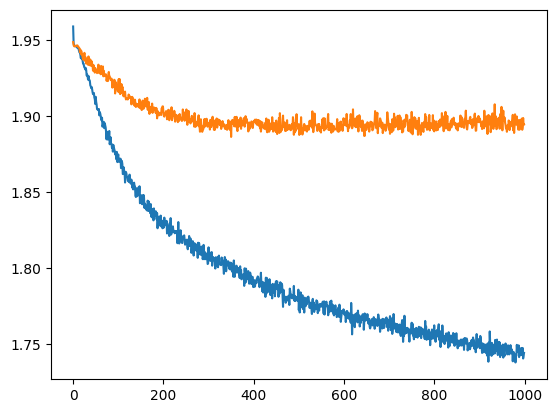

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)

In [ ]:
test=[]
train=[]
for i in range(len(train_acc)):
    train.append(train_acc[i].to('cpu'))
    test.append(test_acc[i].to('cpu'))
print(test)
print(train)

[tensor(0.1413), tensor(0.1425), tensor(0.1462), tensor(0.1456), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1341), tensor(0.1496), tensor(0.1534), tensor(0.1488), tensor(0.1540), tensor(0.1619), tensor(0.1653), tensor(0.1560), tensor(0.1569), tensor(0.1639), tensor(0.1528), tensor(0.1504), tensor(0.1780), tensor(0.1740), tensor(0.1607), tensor(0.1702), tensor(0.1633), tensor(0.1665), tensor(0.1633), tensor(0.1696), tensor(0.1736), tensor(0.1720), tensor(0.1726), tensor(0.1778), tensor(0.1712), tensor(0.1659), tensor(0.1774), tensor(0.1730), tensor(0.1796), tensor(0.1639), tensor(0.1683), tensor(0.1752), tensor(0.1746), tensor(0.1812), tensor(0.1810), tensor(0.1812), tensor(0.1708), tensor(0.1774), tensor(0.1798), tensor(0.1833), tensor(0.1812), tensor(0.1847), tensor(0.1800), tensor(0.1756), tensor(0.1808), tensor(0.1810), tensor(0.1786), tensor(0.1677), tensor(0.1829), tensor(0.1738), tensor(0.1722), tensor(0.1784), tensor(0.1867), tensor(

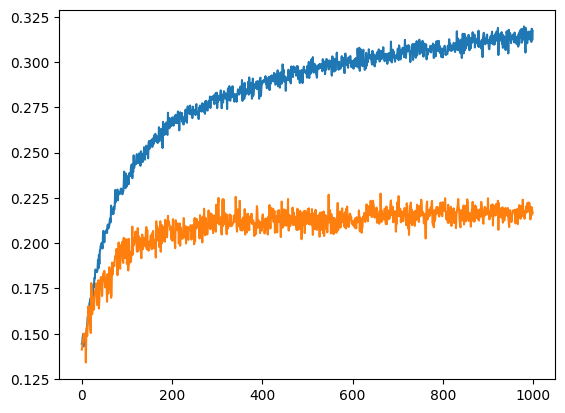

In [ ]:
plt.plot(train)
plt.plot(test)